In [79]:
import yfinance as yahooFinance
import pandas as pd

GetFacebookInformation = yahooFinance.Ticker("RELIANCE.NS")

pd.set_option('display.max_rows', None)
# Let us get historical stock prices for Facebook 
# covering the past few years.
# max->maximum number of daily prices available 
# for Facebook.
# Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 
# 5y, 10y and ytd.
df = GetFacebookInformation.history(period="6mo")


In [80]:
df.to_csv('input_stock_data.csv')

In [1]:
import pandas as pd

In [11]:
df = pd.read_csv('reliance.csv')

In [12]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1996-01-01 00:00:00+05:30,3.792768,3.813119,3.767791,3.806643,104121369,0.0,0.0
1,1996-01-02 00:00:00+05:30,3.797392,3.815893,3.749288,3.777040,168743308,0.0,0.0
2,1996-01-03 00:00:00+05:30,3.839019,4.013856,3.797392,3.805717,209323879,0.0,0.0
3,1996-01-04 00:00:00+05:30,3.769639,3.781665,3.719685,3.770564,216900264,0.0,0.0
4,1996-01-05 00:00:00+05:30,3.755763,3.755763,3.712285,3.744662,166708467,0.0,0.0


In [13]:
df.isna().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [20]:
df['Date'] = pd.to_datetime(df['Date'])

In [22]:
df['Date'] = df['Date'].dt.date

In [23]:
df['Date']

0       1996-01-01
1       1996-01-02
2       1996-01-03
3       1996-01-04
4       1996-01-05
5       1996-01-08
6       1996-01-09
7       1996-01-10
8       1996-01-11
9       1996-01-12
10      1996-01-15
11      1996-01-16
12      1996-01-17
13      1996-01-18
14      1996-01-19
15      1996-01-22
16      1996-01-23
17      1996-01-24
18      1996-01-25
19      1996-01-26
20      1996-01-29
21      1996-01-30
22      1996-01-31
23      1996-02-01
24      1996-02-02
25      1996-02-05
26      1996-02-06
27      1996-02-07
28      1996-02-08
29      1996-02-09
30      1996-02-12
31      1996-02-13
32      1996-02-14
33      1996-02-15
34      1996-02-16
35      1996-02-19
36      1996-02-20
37      1996-02-21
38      1996-02-22
39      1996-02-23
40      1996-02-26
41      1996-02-27
42      1996-02-28
43      1996-02-29
44      1996-03-01
45      1996-03-04
46      1996-03-05
47      1996-03-06
48      1996-03-07
49      1996-03-08
50      1996-03-11
51      1996-03-12
52      1996

In [2]:
import pandas as pd
import pandas_ta as ta  # Technical Analysis Library
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# === Load Stock Data ===
df = pd.read_csv("reliance.csv")

# Ensure Date is a proper datetime type
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# === Convert Daily Data to Weekly ===
df_weekly = df.iloc[::6]

# === Add Technical Indicators for Weekly Data ===

# Trend Indicators
df_weekly['SMA_10'] = df_weekly.ta.sma(length=10)  # Simple Moving Average
df_weekly['EMA_10'] = df_weekly.ta.ema(length=10)  # Exponential Moving Average
# df_weekly[['MACD', 'MACD_Signal', 'MACD_Hist']] = df_weekly.ta.macd()  # MACD
# df_weekly[['BB_High', 'BB_Mid', 'BB_Low']] = df_weekly.ta.bbands()  # Bollinger Bands

# Momentum Indicators
df_weekly['RSI'] = df_weekly.ta.rsi(length=14)  # Relative Strength Index
df_weekly[['StochK', 'StochD']] = df_weekly.ta.stoch()  # Stochastic Oscillator
df_weekly['WilliamsR'] = df_weekly.ta.willr()  # Williams %R

# Volume-Based Indicators
df_weekly['OBV'] = df_weekly.ta.obv()  # On-Balance Volume
df_weekly['VWAP'] = df_weekly.ta.vwap()  # Volume Weighted Average Price

# Volatility Indicators
df_weekly['ATR'] = df_weekly.ta.atr()  # Average True Range
df_weekly['StdDev'] = df_weekly.ta.stdev(length=20)  # Standard Deviation

# === Define Weekly Trading Signals (Target Variable) ===
df_weekly['Signal'] = np.where(df_weekly['Close'].shift(-1) > df_weekly['Close'], 1, 0)  # 1 = Buy, 0 = Sell

# Drop NaN values that may have been introduced
df_weekly.dropna(inplace=True)

# === Prepare Data for XGBoost ===
features = df_weekly.drop(columns=['Signal'])
target = df_weekly['Signal']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Convert Data to XGBoost DMatrix Format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# === Define XGBoost Parameters ===
params = {
    'objective': 'binary:logistic',  # Binary classification (0 or 1)
    'eval_metric': 'logloss',
    'max_depth': 10,
    'learning_rate': 0.2,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# === Train XGBoost Model ===
model = xgb.train(params, dtrain, num_boost_round=200)

# === Make Predictions ===
y_pred = model.predict(dtest)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probability to 0 (Sell) / 1 (Buy)

# === Evaluate Accuracy ===
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Weekly XGBoost Model Accuracy: {accuracy:.4f}")

# === Save Weekly Predictions ===
df_weekly['Predicted_Signal'] = model.predict(xgb.DMatrix(features))
df_weekly['Predicted_Signal'] = np.where(df_weekly['Predicted_Signal'] > 0.5, 1, 0)

df_weekly.to_csv("weekly_stock_predictions.csv")
print("Weekly trading signals saved to weekly_stock_predictions.csv")


C:\Users\sachi\AppData\Local\Temp\ipykernel_11772\3967740691.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['SMA_10'] = df_weekly.ta.sma(length=10)  # Simple Moving Average
C:\Users\sachi\AppData\Local\Temp\ipykernel_11772\3967740691.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['EMA_10'] = df_weekly.ta.ema(length=10)  # Exponential Moving Average
C:\Users\sachi\AppData\Local\Temp\ipykernel_11772\3967740691.py:27: SettingWithCopyWarning: 
A value is trying to be set on a cop

Weekly XGBoost Model Accuracy: 0.5359
Weekly trading signals saved to weekly_stock_predictions.csv


C:\Users\sachi\AppData\Local\Temp\ipykernel_11772\3967740691.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Predicted_Signal'] = model.predict(xgb.DMatrix(features))
C:\Users\sachi\AppData\Local\Temp\ipykernel_11772\3967740691.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weekly['Predicted_Signal'] = np.where(df_weekly['Predicted_Signal'] > 0.5, 1, 0)


      Feature  Importance
4      Volume       755.0
9      StochD       750.0
10  WilliamsR       704.0
8      StochK       652.0
7         RSI       646.0
14     StdDev       599.0
11        OBV       445.0
13        ATR       430.0
0        Open       348.0
5      SMA_10       256.0
6      EMA_10       183.0
1        High       164.0
2         Low       111.0
3       Close        97.0
12       VWAP        33.0


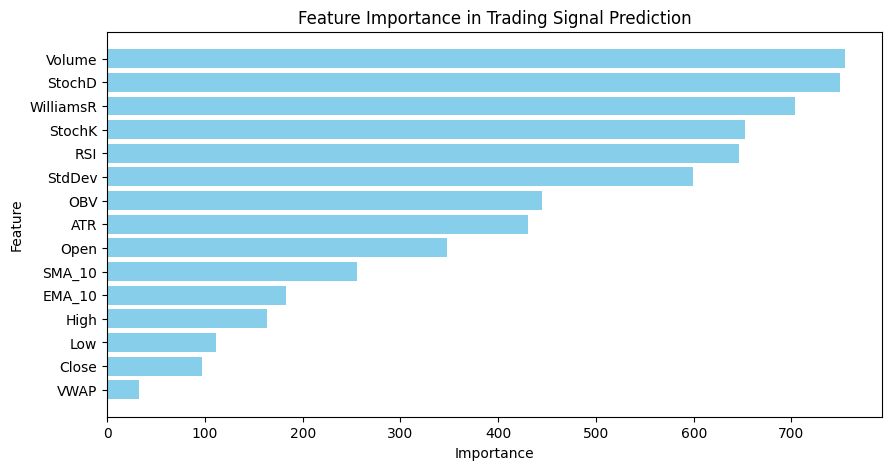

In [3]:
import matplotlib.pyplot as plt

# Get feature importance
importance = model.get_score(importance_type='weight')

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print top important features
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Trading Signal Prediction")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()


In [4]:
input_data = pd.read_csv("input_stock_data.csv")

# Ensure that 'Date' is a proper datetime type if it's included in the data
input_data['Date'] = pd.to_datetime(input_data['Date'])
input_data.set_index('Date', inplace=True)

In [54]:
# input_data = input_data.reset_index(names=['Date','Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'])

In [ ]:
# input_data = input_data[input_data['Date']>'2025-01-08 00:00:00+05:30']

In [5]:
input_data = input_data.iloc[::6]

In [6]:
input_data['SMA_10'] = input_data.ta.sma(length=10)
input_data['EMA_10'] = input_data.ta.ema(length=10)

In [7]:
input_data['RSI'] = input_data.ta.rsi(length=14)
input_data[['StochK', 'StochD']] = input_data.ta.stoch()
input_data['WilliamsR'] = input_data.ta.willr()
input_data['OBV'] = input_data.ta.obv()
input_data['VWAP'] = input_data.ta.vwap()
input_data['ATR'] = input_data.ta.atr()
input_data['StdDev'] = input_data.ta.stdev(length=20)

C:\Users\sachi\AppData\Local\Temp\ipykernel_11772\1802044529.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  input_data['VWAP'] = input_data.ta.vwap()


In [9]:
pred_data = input_data[input_data.index == '2025-01-22 00:00:00+05:30']

In [10]:
features = pred_data

In [11]:
pred_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_10,EMA_10,RSI,StochK,StochD,WilliamsR,OBV,VWAP,ATR,StdDev
Date,,,,,,,,,,,,,,,,,
2025-01-22 00:00:00+05:30,1278.300049,1282.900024,1268.699951,1277.099976,10273590,0.0,0.0,1264.395007,1280.655237,35.489735,9.554532,5.674695,-79.966133,-104288281.0,1276.233317,43.233021,105.630456


In [12]:
dinput = xgb.DMatrix(features)
predictions = model.predict(dinput)

In [13]:
predictions_binary = np.where(predictions > 0.5, 1, 0)


In [14]:
predictions_binary

array([0])

In [147]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Program Files (x86)\Graphviz\bin'

<Figure size 20000x10000 with 0 Axes>

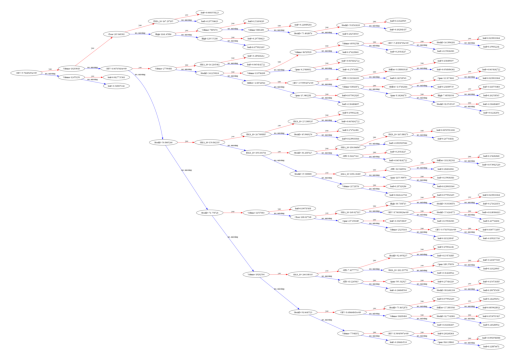

In [157]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the trained model (make sure to load your model here)
# model = xgb.Booster()
# model.load_model('xgboost_trained_model.model')  # Replace with your model file path

# Plot the first tree (tree index 0)
plt.figure(figsize=(200,100))  # Adjust the size of the plot as needed
xgb.plot_tree(model,rankdir='LR')
plt.savefig('tree.png',dpi=2000)# num_trees specifies the index of the tree to plot
plt.show()

# Plot additional trees (e.g., second tree)
# plt.figure(figsize=(20,10))
# xgb.plot_tree(model, num_trees=1)# Change to other tree index if you want to plot different trees

# plt.show()


In [35]:
import shap
  # Replace with your trained model path

# Load or prepare the feature data for prediction
# Ensure 'feature_names' is the same as what was used for training
feature_names = pred_data.columns.to_list()

# Example: Suppose you want to explain prediction for a specific day's data
example_input = pred_data  # Replace with actual data

# Convert to DMatrix (same format as training)
dexample = xgb.DMatrix(example_input, feature_names=feature_names)

# Make prediction
predicted_value = model.predict(dexample)[0]
print(f"Predicted Output: {predicted_value}")

# Explain the prediction using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(example_input)

Predicted Output: 0.06120007485151291


In [54]:
preds = model.predict(dtest)

In [62]:
np.where(preds > 0.5)

(array([  0,   2,   4,   6,   7,   8,   9,  10,  12,  13,  17,  18,  20,
         22,  24,  25,  27,  29,  30,  36,  37,  38,  39,  40,  41,  43,
         44,  45,  46,  49,  50,  51,  52,  53,  55,  58,  59,  60,  61,
         65,  67,  68,  69,  70,  71,  72,  73,  74,  75,  78,  79,  80,
         82,  83,  84,  86,  91,  93,  97,  98,  99, 101, 103, 106, 107,
        110, 111, 113, 114, 115, 117, 118, 120, 121, 122, 124, 125, 128,
        130, 131, 132, 133, 134, 135, 137, 138, 139, 141, 143, 144, 146,
        147, 148, 149, 151, 154, 155, 157, 159, 161, 164, 166, 167, 168,
        171, 175, 176, 179, 181, 183, 184, 185, 191, 192, 193, 194, 195,
        198, 200, 202, 203, 204, 205, 206, 208, 210, 212, 214, 215, 220,
        222, 223, 224, 225, 227, 229, 231, 233, 234, 235, 236]),)

In [47]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [45]:
np.sum(shap_values.values[0])

np.float32(-2.8514988)

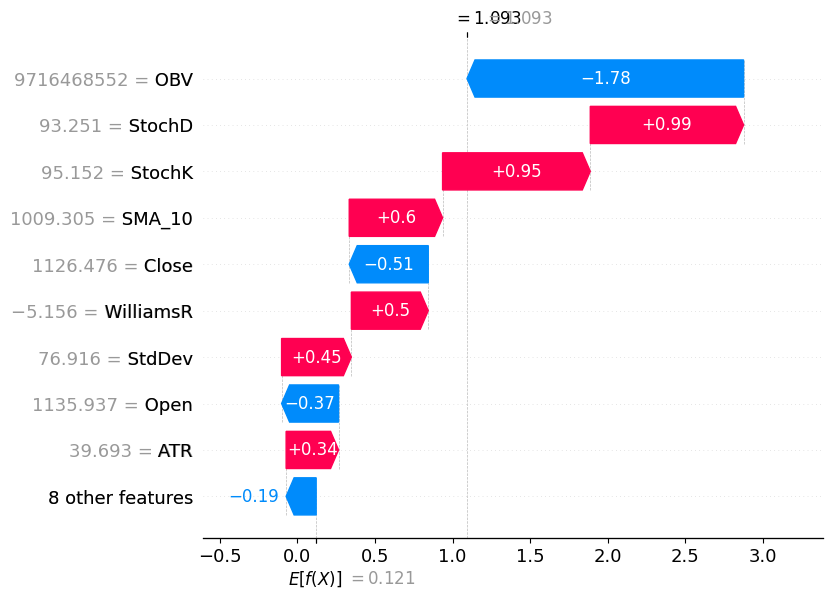

In [64]:
shap.plots.waterfall(shap_values[2])

In [65]:
shap.plots.force(shap_values[2])

In [50]:
shap.plots.force(shap_values[0:100])

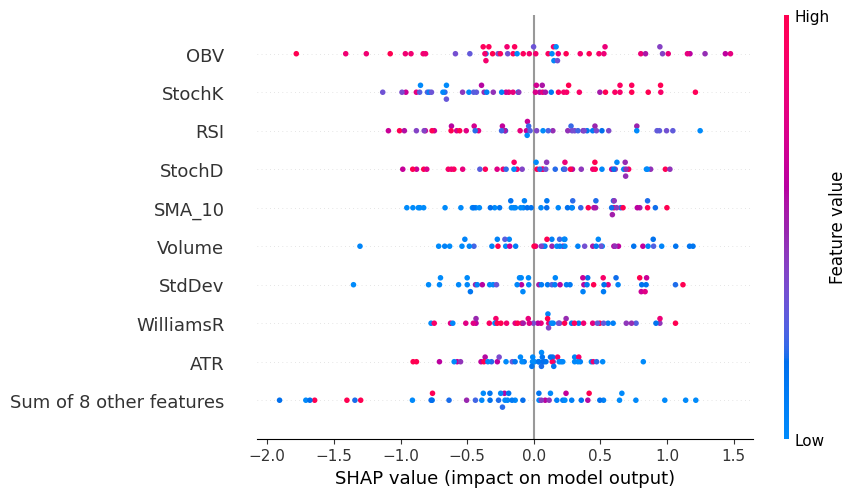

In [53]:
shap.plots.beeswarm(shap_values[0:50])

In [1]:
import pandas as pd
import yfinance as yahooFinance
import os
import pandas_ta as ta  # Technical Analysis Library
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle 
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import csv
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:

symbol_df = pd.read_csv('../data/nifty500list.csv')

In [19]:

for i in range(len(symbol_df)):
    
    GetFacebookInformation = yahooFinance.Ticker(f'{symbol_df["Stock"][i]}.NS')

    # Let us get historical stock prices for Facebook 
    # covering the past few years.
    # max->maximum number of daily prices available 
    # for Facebook.
    # Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 
    # 5y, 10y and ytd.
    df = GetFacebookInformation.history(period="max")
    df.to_csv(f'../data/stock_data/{symbol_df["Stock"][i]}.csv')

In [20]:


# Directory containing CSV files
directory = "../data/stock_data"

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)  # Read CSV into a DataFrame
        df['Date'] = pd.to_datetime(df['Date'])
        df['Day'] = df['Date'].dt.day_name()
        df = df.loc[:, ~df.columns.str.startswith("Unnamed")]
        df.to_csv(f'../data/stock_data/{filename.split(".")[0]}.csv',index=False)


- calculate indicator daily
- take every 5th row
- predict for next row, which is 

In [33]:
df = pd.read_csv('../data/stock_data/AADHARHFC.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# === Add Technical Indicators for Weekly Data ===

# Trend Indicators
df['SMA_10'] = df.ta.sma(length=10)  # Simple Moving Average
df['SMA_20'] = df.ta.sma(length=20)
df['SMA_50'] = df.ta.sma(length=50)
df['SMA_100'] = df.ta.sma(length=100)
# df['SMA_200'] = df.ta.sma(length=200)
df['EMA_5'] = df.ta.ema(length=5)
df['EMA_9'] = df.ta.ema(length=9)
df['EMA_20'] = df.ta.ema(length=20)
df['EMA_50'] = df.ta.ema(length=50)
df['EMA_100'] = df.ta.ema(length=100)
# df['EMA_200'] = df.ta.ema(length=200)

In [34]:
df['ADX'] = df.ta.adx(length=14)['ADX_14']

In [35]:
df['A/D'] = df.ta.ad()

In [36]:
df['RSI'] = df.ta.rsi(length=14)  # Relative Strength Index
df[['StochK', 'StochD']] = df.ta.stoch()  # Stochastic Oscillator
df['WilliamsR'] = df.ta.willr()  # Williams %R

# Volume-Based Indicators
df['OBV'] = df.ta.obv()  # On-Balance Volume
df['VWAP'] = df.ta.vwap()  # Volume Weighted Average Price

# Volatility Indicators
df['ATR'] = df.ta.atr()  # Average True Range
df['StdDev'] = df.ta.stdev(length=20)  # Standard Deviation

df = df[df['Day'] == 'Friday']

# === Define Weekly Trading Signals (Target Variable) ===
# df['Signal'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

In [37]:
df.dropna(inplace=True)
df['Signal'] = np.where(df['Close'].shift(-1) > (df['Close'] + df['Close']*0.03), 1, 0)
# === Prepare Data for XGBoost ===
features = df.drop(columns=['Signal','Dividends', 'Stock Splits','Day']).values
target = df['Signal'].values



In [47]:
# Convert data into time-series sequences
def create_sequences(data, labels, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(labels[i + seq_length])
    return np.array(X), np.array(y)

# === 2️⃣ Train-Test Split (WITHOUT SHUFFLING) ===
train_size = int(len(features) * 0.8)
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

# Apply Standard Scaler AFTER splitting (to prevent data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Create sequences
seq_length = 10 # Lookback period
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_length)

# Convert to PyTorch tensors
X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [48]:
X_train_seq.shape

torch.Size([2, 10, 24])

In [49]:
X_test_seq

tensor([])

In [41]:
# # === Define LSTM Model ===
# class StockLSTM(nn.Module):
#     def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
#         super(StockLSTM, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(0.2)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         x = self.fc(lstm_out[:, -1, :])  # Take last LSTM output
#         x = self.dropout(x)
#         return self.sigmoid(x)

# === 3️⃣ Define CNN-LSTM Model ===
class CNN_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, lstm_layers, output_dim):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

        # LSTM input (batch_size, sequence_length, input_size) and output (batch, seq length, hidden size)
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_dim, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape for Conv1D
        x = self.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Change back for LSTM
        lstm_out, _ = self.lstm(x)
        # print(lstm_out.shape)
        # print(lstm_out[:,-1,:].shape)
        x = self.fc(lstm_out[:, -1, :])
        return self.sigmoid(x)



In [42]:
input_dim = X_train_seq.shape[2] 
hidden_dim = 128  # Number of LSTM neurons
lstm_layers = 2   # Stacked LSTM layers
output_dim = 1    

model = CNN_LSTM(input_dim, hidden_dim, lstm_layers, output_dim)

# Define Loss & Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [43]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 16
# Create dataset
train_dataset = TensorDataset(X_train_seq, y_train_seq)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)


In [46]:
X_test_seq

tensor([])

In [44]:
# === Train LSTM Model ===
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    
    for batch_X, batch_y in train_loader:  # Iterate through mini-batches
        optimizer.zero_grad()
        outputs = model(batch_X)  # Forward pass
        # print(batch_y.shape)
        outputs = outputs.view(-1, 1)  # Ensure correct shape
        batch_y = batch_y.view(-1, 1)  # Ensure correct shape
        loss = criterion(outputs, batch_y)  # Compute loss
        # print(loss)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# === Evaluate Model ===
model.eval()
with torch.no_grad():
    y_pred = model(X_test_seq)
    y_pred_binary = (y_pred > 0.5).float()
    accuracy = accuracy_score(y_test_seq.cpu().numpy(), y_pred_binary.cpu().numpy())


Epoch [0/50], Loss: 0.6516
Epoch [10/50], Loss: 0.0535
Epoch [20/50], Loss: 0.0023
Epoch [30/50], Loss: 0.0010
Epoch [40/50], Loss: 0.0007


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 1 is not equal to len(dims) = 3

In [98]:
accuracy

0.7264957264957265

In [16]:
params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'max_depth': 10,
            'learning_rate': 0.2,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,  # Ensure reproducibility
            'seed': 42
        }

# === Train XGBoost Model ===
model = xgb.train(
    params, 
    dtrain, 
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=5, 
    num_boost_round=200
    )

# print(X_test)
y_pred = model.predict(dtest)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred_binary)

[0]	train-logloss:0.50603	validation-logloss:0.57412
[1]	train-logloss:0.46437	validation-logloss:0.57582


[2]	train-logloss:0.42709	validation-logloss:0.59001
[3]	train-logloss:0.39154	validation-logloss:0.60104
[4]	train-logloss:0.36221	validation-logloss:0.60322
[5]	train-logloss:0.33304	validation-logloss:0.60944


In [17]:
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probability to 0 (Sell) / 1 (Buy)

# === Evaluate Accuracy ===
accuracy = accuracy_score(y_test, y_pred_binary)
# accuracies[f'{filename.split(".")[0]}'] = accuracy

# === Save Weekly Predictions ===
df['Predicted_Signal'] = model.predict(xgb.DMatrix(features))
df['Predicted_Signal'] = np.where(df['Predicted_Signal'] > 0.5, 1, 0)

In [ ]:
accuracies = {}

# === Load Stock Data ===
directory = "../data/stock_data"

# Loop through all files in the directory
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path)
        df = df[df['Date'] < '2025-02-14 00:00:00+05:30']

        try:
            # Ensure Date is a proper datetime type
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)


            # Trend Indicators
            df['SMA_10'] = df.ta.sma(length=10)  # Simple Moving Average
            df['SMA_20'] = df.ta.sma(length=20)
            df['SMA_50'] = df.ta.sma(length=50)
            df['SMA_100'] = df.ta.sma(length=100)
            # df['SMA_200'] = df.ta.sma(length=200)
            df['EMA_5'] = df.ta.ema(length=5)
            df['EMA_9'] = df.ta.ema(length=9)  # Exponential Moving Average
            df['EMA_20'] = df.ta.ema(length=20)
            df['EMA_50'] = df.ta.ema(length=50)
            df['EMA_100'] = df.ta.ema(length=100)
            # df['EMA_200'] = df.ta.ema(length=200)
            
            df['ADX'] = df.ta.adx(length=14)['ADX_14']
            
            df['A/D'] = df.ta.ad()

            df['RSI'] = df.ta.rsi(length=14)  # Relative Strength Index
            
            df[['StochK_14_3_3_14', 'StochD_14_3_3_14']] = df.ta.stoch()  # Stochastic Oscillator
            df[['StochK_3_3_14_14', 'StochD_3_3_14_14']] = df.ta.stoch(k=3,d=3,smooth_k=14)
            
            df['WilliamsR'] = df.ta.willr()  # Williams %R

            # Volume-Based Indicators
            df['OBV'] = df.ta.obv()  # On-Balance Volume
            df['VWAP'] = df.ta.vwap()  # Volume Weighted Average Price

            # Volatility Indicators
            df['ATR'] = df.ta.atr()  # Average True Range
            df['StdDev'] = df.ta.stdev(length=20)  # Standard Deviation
            
            df = df[df['Day'] == 'Friday']

            # === Define Weekly Trading Signals (Target Variable) ===
            df['Signal'] = np.where(df['Close'].shift(-1) > (df['Close'] + df['Close']*0.03), 1, 0)  # 1 = Buy, 0 = Sell

            # Drop NaN values that may have been introduced
            df.dropna(inplace=True)

            # === Prepare Data for XGBoost ===
            features = df.drop(columns=['Signal','Dividends', 'Stock Splits','Day'])
            target = df['Signal']
            
            X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.4, random_state=42)
            X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

            # X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
            
            scaler = StandardScaler()
            std_model = scaler.fit(X_train)
            
            pickle.dump(std_model, open(f'../data/standard_scaler/{filename.split(".")[0]}.pkl', "wb"))
            
            X_train_scaled = pd.DataFrame(std_model.transform(X_train), columns=X_train.columns, index=X_train.index)
            X_test_scaled = pd.DataFrame(std_model.transform(X_test), columns=X_test.columns, index=X_test.index)
            X_val_scaled = pd.DataFrame(std_model.transform(X_val), columns=X_val.columns, index=X_val.index)

            # Convert Data to XGBoost DMatrix Format
            dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
            dtest = xgb.DMatrix(X_test_scaled, label=y_test)
            dval = xgb.DMatrix(X_val_scaled, label=y_val)

            # === Define XGBoost Parameters ===
            params = {
                        'objective': 'binary:logistic',
                        'eval_metric': 'logloss',
                        'max_depth': 10,
                        'learning_rate': 0.2,
                        'subsample': 0.8,
                        'colsample_bytree': 0.8,
                        'random_state': 42,  # Ensure reproducibility
                        'seed': 42
                    }

            # === Train XGBoost Model ===
            model = xgb.train(
                params, 
                dtrain, 
                evals=[(dtrain, 'train'), (dval, 'validation')],
                early_stopping_rounds=5, 
                num_boost_round=200,
                verbose_eval=False
                )

            # === Make Predictions ===
            y_pred = model.predict(dtest)
            y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # Convert probability to 0 (Sell) / 1 (Buy)

            # === Evaluate Accuracy ===
            accuracy = accuracy_score(y_test, y_pred_binary)
            accuracies[f'{filename.split(".")[0]}'] = accuracy

            # === Save Weekly Predictions ===
            df['Predicted_Signal'] = model.predict(xgb.DMatrix(features))
            df['Predicted_Signal'] = np.where(df['Predicted_Signal'] > 0.5, 1, 0)

            df.to_csv(f'../data/pred_data/pred_{filename.split(".")[0]}.csv',index=False)

            # save
            pickle.dump(model, open(f'../data/model/xgb_{filename.split(".")[0]}.pkl', "wb"))
        except Exception as e:
            print(f'Error in {filename}: {e}')

  0%|          | 0/497 [00:00<?, ?it/s]

100%|██████████| 497/497 [02:47<00:00,  2.96it/s]


In [60]:

header = ['Stock', 'accuracy']
with open('../data/accuracies.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    writer.writerow(header)
    for key, value in accuracies.items():
       writer.writerow([key, value])

In [63]:

for i in range(len(symbol_df)):
    
    GetFacebookInformation = yahooFinance.Ticker(f'{symbol_df["Stock"][i]}.NS')

    # Let us get historical stock prices for Facebook 
    # covering the past few years.
    # max->maximum number of daily prices available 
    # for Facebook.
    # Valid options are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 
    # 5y, 10y and ytd.
    df = GetFacebookInformation.history(period="6mo")
    df.to_csv(f'../data/fut_data/{symbol_df["Stock"][i]}.csv')

In [66]:
directory = "../data/fut_data"
fut_pred = {}

# Loop through all files in the directory
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".csv"):  # Check if the file is a CSV
        file_path = os.path.join(directory, filename)
        
        input_data = pd.read_csv(file_path)
        # print(filename)
        
        

        # Ensure that 'Date' is a proper datetime type if it's included in the data
        input_data['Date'] = pd.to_datetime(input_data['Date'])
        
        input_data = input_data[input_data['Date'] < '2025-02-01 00:00:00+05:30']
        # print(input_data)
        input_data.set_index('Date', inplace=True)

        input_data['SMA_10'] = input_data.ta.sma(length=10)  # Simple Moving Average
        input_data['SMA_20'] = input_data.ta.sma(length=20)
        input_data['SMA_50'] = input_data.ta.sma(length=50)
        input_data['SMA_100'] = input_data.ta.sma(length=100)
        # input_data['SMA_200'] = input_data.ta.sma(length=200)
        
        input_data['EMA_5'] = input_data.ta.ema(length=5)
        input_data['EMA_9'] = input_data.ta.ema(length=9)  # Exponential Moving Average
        input_data['EMA_20'] = input_data.ta.ema(length=20)
        input_data['EMA_50'] = input_data.ta.ema(length=50)
        input_data['EMA_100'] = input_data.ta.ema(length=100)
        # input_data['EMA_200'] = input_data.ta.ema(length=200)
        
        input_data['ADX'] = input_data.ta.adx(length=14)['ADX_14']
        
        input_data['A/D'] = input_data.ta.ad()

        input_data['RSI'] = input_data.ta.rsi(length=14)  # Relative Strength Index
        # input_data[['StochK', 'StochD']] = input_data.ta.stoch()  # Stochastic Oscillator
        input_data[['StochK_14_3_3_14', 'StochD_14_3_3_14']] = input_data.ta.stoch()  # Stochastic Oscillator
        input_data[['StochK_3_3_14_14', 'StochD_3_3_14_14']] = input_data.ta.stoch(k=3,d=3,smooth_k=14)
            
        input_data['WilliamsR'] = input_data.ta.willr()  # Williams %R

        # Volume-Based Indicators
        input_data['OBV'] = input_data.ta.obv()  # On-Balance Volume
        input_data['VWAP'] = input_data.ta.vwap()  # Volume Weighted Average Price

        # Volatility Indicators
        input_data['ATR'] = input_data.ta.atr()  # Average True Range
        input_data['StdDev'] = input_data.ta.stdev(length=20)  # Standard Deviation
        # print(input_data.head(5))

        features = input_data[input_data.index == '2025-01-31 00:00:00+05:30']
        features = features.drop(columns=['Dividends', 'Stock Splits'])
        std_model = pickle.load(open(f'../data/standard_scaler/{filename.split(".")[0]}.pkl', 'rb'))
        scaled_feat = pd.DataFrame(std_model.transform(features), columns=features.columns, index=features.index)

        # print(features)
        dinput = xgb.DMatrix(scaled_feat)
        loaded_model = pickle.load(open(f'../data/model/xgb_{filename.split(".")[0]}.pkl', 'rb'))
        predictions = loaded_model.predict(dinput)
        predictions_binary = np.where(predictions > 0.5, 1, 0)
        fut_pred[f'{filename.split(".")[0]}'] = [predictions_binary,predictions[0]]

100%|██████████| 497/497 [00:22<00:00, 21.67it/s]


In [67]:
fut_pred

{'360ONE': [array([1]), np.float32(0.8220193)],
 '3MINDIA': [array([0]), np.float32(0.008915251)],
 'AADHARHFC': [array([0]), np.float32(0.32718644)],
 'AARTIIND': [array([0]), np.float32(0.18304203)],
 'AAVAS': [array([0]), np.float32(0.00782364)],
 'ABB': [array([0]), np.float32(0.1735452)],
 'ABBOTINDIA': [array([0]), np.float32(0.06577446)],
 'ABCAPITAL': [array([0]), np.float32(0.0011038107)],
 'ABFRL': [array([0]), np.float32(0.004099392)],
 'ABREL': [array([0]), np.float32(0.035500437)],
 'ABSLAMC': [array([0]), np.float32(0.03376956)],
 'ACC': [array([0]), np.float32(0.02149866)],
 'ACE': [array([0]), np.float32(0.17329803)],
 'ACI': [array([0]), np.float32(0.3235367)],
 'ADANIENSOL': [array([1]), np.float32(0.9867012)],
 'ADANIENT': [array([0]), np.float32(0.14642039)],
 'ADANIGREEN': [array([0]), np.float32(0.050711147)],
 'ADANIPORTS': [array([0]), np.float32(0.004228922)],
 'ADANIPOWER': [array([0]), np.float32(0.011249307)],
 'AEGISLOG': [array([0]), np.float32(0.3395037)]

In [68]:
weekly_prediction = pd.DataFrame(
    [(symbol, values[0][0], values[1]) for symbol, values in fut_pred.items()],
    columns=["Stock", "Signal", "Probability"]
)

In [69]:
acc = pd.read_csv('../data/accuracies.csv')

In [9]:
weekly_prediction = pd.read_csv('../data/weekly_prediction(3feb-7feb).csv')

In [70]:
weekly_prediction = weekly_prediction.merge(acc, on='Stock', how='inner')

In [76]:
weekly_prediction.to_csv('../data/weekly_prediction(3feb-7feb).csv',index=False)

In [93]:
weekly_prediction.sort_values('accuracy',ascending=False)

,Stock,Signal,Probability,accuracy
448,TBOTEK,1,0.612182,1.000000
2,AADHARHFC,0,0.227803,1.000000
472,UNITDSPR,0,0.233279,1.000000
71,BHARTIHEXA,1,0.712386,1.000000
207,HONASA,0,0.053590,0.888889
...,...,...,...,...
334,NETWEB,1,0.607976,0.363636
279,KPIL,0,0.281713,0.363636
481,VIJAYA,0,0.043077,0.333333
270,KAYNES,0,0.026160,0.333333


- last friday close comparison with close of prices till friday in percentage
- with signal, probability, accuracy

In [3]:
GetFacebookInformation = yahooFinance.Ticker(f'3MINDIA.NS')
df = GetFacebookInformation.history(period="5d")
df.reset_index(level=0,inplace=True)

In [182]:
target_date = '2025-01-31 00:00:00+05:30'
target_column = df[df['Date'] == target_date]

In [183]:
df = df[df['Date'] > target_date].drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],axis=1)

In [185]:
df['Target Close'] = target_column['Close'].values[0]

In [187]:
df['Difference'] = df['Close'] - df['Target Close']

In [191]:
df['Percentage'] = df['Difference'] / df['Target Close'] *100

In [198]:
df

,Date,Close,Target Close,Difference,Percentage
20,2025-02-03 00:00:00+05:30,29464.849609,29892.25,-427.400391,-1.429803
21,2025-02-04 00:00:00+05:30,28756.150391,29892.25,-1136.099609,-3.800649
22,2025-02-05 00:00:00+05:30,28495.099609,29892.25,-1397.150391,-4.673955
23,2025-02-06 00:00:00+05:30,28485.800781,29892.25,-1406.449219,-4.705063


In [202]:
if(df['Percentage'] > 3).any():
    print('yes')
else:
    print('no')

no


In [71]:
success_stocks = []
for i in tqdm(range(len(symbol_df))):
    GetFacebookInformation = yahooFinance.Ticker(f'{symbol_df["Stock"][i]}.NS')
    df = GetFacebookInformation.history(period="1mo")
    df.reset_index(level=0,inplace=True)
    target_date = '2025-01-31 00:00:00+05:30'
    target_column = df[df['Date'] == target_date]
    df = df[df['Date'] > target_date].drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],axis=1)
    df['Target Close'] = target_column['Close'].values[0]
    df['Difference'] = df['Close'] - df['Target Close']
    df['Percentage'] = df['Difference'] / df['Target Close'] *100
    prediction_data = weekly_prediction[weekly_prediction['Stock'] == symbol_df["Stock"][i]]
    df['Signal'] = prediction_data['Signal'].values[0]
    df['Probability'] = prediction_data['Probability'].values[0]
    df['accuracy'] = prediction_data['accuracy'].values[0]
    if((df['Percentage'] > 3) &(df['Signal'] == 1)).any():
        success_stocks.append([symbol_df["Stock"][i], prediction_data['Probability'].values[0], prediction_data['accuracy'].values[0]])
    df.to_csv(f'../data/after_week_pred/{symbol_df["Stock"][i]}.csv',index=False)
    

100%|██████████| 497/497 [01:11<00:00,  6.96it/s]


In [225]:
failed_stocks = []
for i in tqdm(range(len(symbol_df))):
    GetFacebookInformation = yahooFinance.Ticker(f'{symbol_df["Stock"][i]}.NS')
    df = GetFacebookInformation.history(period="1mo")
    df.reset_index(level=0,inplace=True)
    target_date = '2025-01-31 00:00:00+05:30'
    target_column = df[df['Date'] == target_date]
    df = df[df['Date'] > target_date].drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],axis=1)
    df['Target Close'] = target_column['Close'].values[0]
    df['Difference'] = df['Close'] - df['Target Close']
    df['Percentage'] = df['Difference'] / df['Target Close'] *100
    prediction_data = weekly_prediction[weekly_prediction['Stock'] == symbol_df["Stock"][i]]
    df['Signal'] = prediction_data['Signal'].values[0]
    df['Probability'] = prediction_data['Probability'].values[0]
    df['accuracy'] = prediction_data['accuracy'].values[0]
    if((df['Percentage'] > 3) &(df['Signal'] == 0)).any():
        failed_stocks.append([symbol_df["Stock"][i], prediction_data['Probability'].values[0], prediction_data['accuracy'].values[0]])
    # df.to_csv(f'../data/after_week_pred/{symbol_df["Stock"][i]}.csv',index=False)

100%|██████████| 497/497 [01:30<00:00,  5.48it/s]


In [228]:
failed_stocks

[['AARTIIND', np.float32(0.18351299), np.float64(0.6866359447004609)],
 ['ABBOTINDIA', np.float32(0.13174959), np.float64(0.7919463087248322)],
 ['ABFRL', np.float32(0.0004661959), np.float64(0.6851851851851852)],
 ['ABREL', np.float32(0.100479476), np.float64(0.6702508960573477)],
 ['ABSLAMC', np.float32(0.033499118), np.float64(0.7241379310344828)],
 ['ADANIPORTS', np.float32(0.04171976), np.float64(0.6134969325153374)],
 ['AEGISLOG', np.float32(0.3505602), np.float64(0.6666666666666666)],
 ['AFFLE', np.float32(0.20608987), np.float64(0.6)],
 ['AJANTPHARM', np.float32(0.06805447), np.float64(0.7096774193548387)],
 ['ALKEM', np.float32(0.13510607), np.float64(0.813953488372093)],
 ['ALKYLAMINE', np.float32(0.26007926), np.float64(0.7006369426751592)],
 ['AMBER', np.float32(0.29775718), np.float64(0.7384615384615385)],
 ['ANANDRATHI', np.float32(0.17599498), np.float64(0.6428571428571429)],
 ['ANANTRAJ', np.float32(0.12793109), np.float64(0.5828571428571429)],
 ['APTUS', np.float32(0.0

In [220]:
len(failed_stocks)

173

In [221]:
len(weekly_prediction[weekly_prediction['Signal'] == 0])

449

In [72]:
success_stocks

[['ADANIENSOL', np.float32(0.9867012), np.float64(0.9090909090909092)],
 ['ALKYLAMINE', np.float32(0.7417796), np.float64(0.6496815286624203)],
 ['ARE&M', np.float32(0.5885014), np.float64(0.6666666666666666)],
 ['ASTRAZEN', np.float32(0.54702747), np.float64(0.7383177570093458)],
 ['BHARTIHEXA', np.float32(0.76923835), np.float64(1.0)],
 ['BIKAJI', np.float32(0.71167976), np.float64(0.7222222222222222)],
 ['CENTURYPLY', np.float32(0.7372638), np.float64(0.6777777777777778)],
 ['CHALET', np.float32(0.9241722), np.float64(0.6909090909090909)],
 ['CRAFTSMAN', np.float32(0.96388775), np.float64(0.7058823529411765)],
 ['GMRAIRPORT', np.float32(0.850319), np.float64(0.6514285714285715)],
 ['GODREJIND', np.float32(0.5722057), np.float64(0.6962616822429907)],
 ['GRAPHITE', np.float32(0.7902871), np.float64(0.6405529953917051)],
 ['IDEA', np.float32(0.6410299), np.float64(0.6)],
 ['INDIACEM', np.float32(0.6444136), np.float64(0.6594982078853047)],
 ['INDIAMART', np.float32(0.82188785), np.floa

In [13]:
success_stocks

[['ADANIENSOL', np.float64(0.8783819), np.float64(0.6363636363636364)],
 ['ANGELONE', np.float64(0.61695206), np.float64(0.6410256410256411)],
 ['ARE&M', np.float64(0.53463435), np.float64(0.6666666666666666)],
 ['BHARTIHEXA', np.float64(0.7123863), np.float64(1.0)],
 ['CENTURYPLY', np.float64(0.55820864), np.float64(0.6555555555555556)],
 ['CHALET', np.float64(0.96716076), np.float64(0.7090909090909091)],
 ['CHOLAFIN', np.float64(0.6677705), np.float64(0.6774193548387096)],
 ['CRAFTSMAN', np.float64(0.7400277), np.float64(0.6176470588235294)],
 ['GMRAIRPORT', np.float64(0.56562126), np.float64(0.6457142857142857)],
 ['GODREJIND', np.float64(0.52835274), np.float64(0.6448598130841121)],
 ['GRAPHITE', np.float64(0.584834), np.float64(0.6267281105990783)],
 ['HDFCAMC', np.float64(0.5955477), np.float64(0.6833333333333333)],
 ['HSCL', np.float64(0.86985964), np.float64(0.7)],
 ['INDIACEM', np.float64(0.5821347), np.float64(0.6666666666666666)],
 ['INDIAMART', np.float64(0.6274902), np.flo

In [74]:
len(success_stocks)

25

In [73]:
len(weekly_prediction[weekly_prediction['Signal'] == 1])

43

In [75]:
25/43

0.5813953488372093

In [77]:
weekly_prediction[weekly_prediction['Signal'] == 1]

,Stock,Signal,Probability,accuracy
0,360ONE,1,0.822019,0.734694
14,ADANIENSOL,1,0.986701,0.909091
24,ALKYLAMINE,1,0.741780,0.649682
31,APARINDS,1,0.742918,0.675127
37,ARE&M,1,0.588501,0.666667
43,ASTRAZEN,1,0.547027,0.738318
71,BHARTIHEXA,1,0.769238,1.000000
73,BIKAJI,1,0.711680,0.722222
79,BOSCHLTD,1,0.716428,0.755760
97,CENTURYPLY,1,0.737264,0.677778


- VIPIND    R
- QUESS     R
- PRESTIGE  R
- PNCINFRA  W
- OBEROIRLTY    W
- NAUKRI    R
- MANKIND   R
- LT        W
- LATENTVIEW    R
- HUDCO     W
- HSCL      R
- GRAPHITE  R
- GMRAIRPORT    R
- ELECON    
- CHOLAFIN  R
- CHALET    R
- CENTURYPLY    R
- ADANIENSOL    R

In [81]:
loaded_model = pickle.load(open('../data/model/xgb_CHALET.pkl','rb'))

             Feature  Importance
4             Volume       119.0
14               ADX       104.0
25            StdDev       102.0
21         WilliamsR        87.0
20  StochD_3_3_14_14        84.0
17  StochK_14_3_3_14        82.0
19  StochK_3_3_14_14        78.0
24               ATR        76.0
16               RSI        75.0
18  StochD_14_3_3_14        75.0
15               A/D        71.0
22               OBV        38.0
0               Open        31.0
1               High        23.0
8            SMA_100        23.0
3              Close        22.0
5             SMA_10        20.0
7             SMA_50        20.0
6             SMA_20        17.0
2                Low        11.0
13           EMA_100        11.0
9              EMA_5         3.0
10             EMA_9         3.0
12            EMA_50         3.0
23              VWAP         2.0
11            EMA_20         1.0


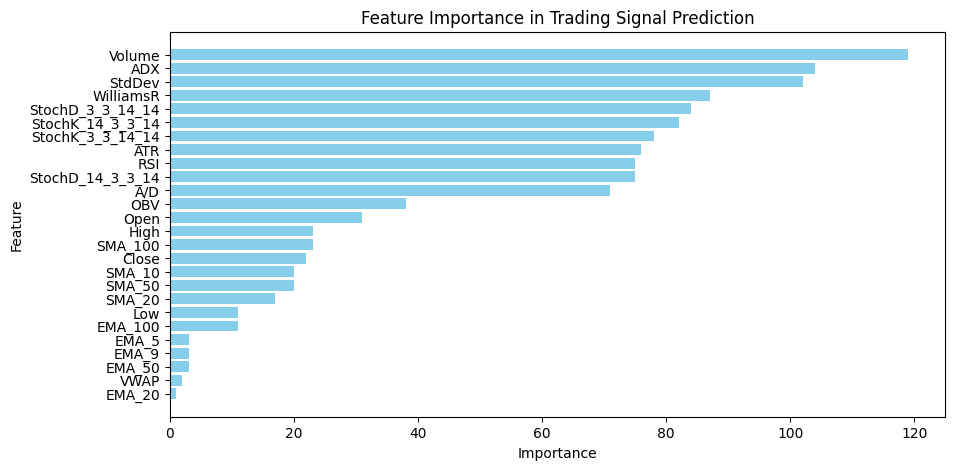

In [82]:
import matplotlib.pyplot as plt

# Get feature importance
importance = loaded_model.get_score(importance_type='weight')

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print top important features
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Trading Signal Prediction")
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()
